In [4]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

Precompiling packages...
  14713.8 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 16 seconds. 512 already precompiled.


In [5]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions, StatsBase
using FreqTables

In [6]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup

In [4]:
# can add a copy of example_do_rg_run if we need more flexibility

# Testing

In [11]:
rsg = RSGJans1(10, 10;
    m=(0.3, 1e-4),
    r=(0.3, 1e-6),
    sparsity_influx=0.8, K=(0.1, 1e-6),
    
    c=(2., 1e-4),
    l=0.5,
    sparsity_resources=0.1,
    sparsity_byproducts=0.1,
    
    Ds=1e-8, Dr=1.,
)
@time xx = example_do_rg_run2(rsg, nthreads(), 100., 1000;
    extinctthr=1e-10,
    return_int=:all,
    return_int_sss=true,
    maxresidthr=1e-13,
    maxiters=100000,
)
countmap(xx[1])

Generating one params: 0.000016 seconds (48 allocations: 13.672 KiB)
  0.194364 seconds (1.66 M allocations: 699.400 MiB)


Dict{Int64, Int64} with 1 entry:
  1 => 18

┌ Error: Error watching manifest
│   exception =
│    cannot set type for global Pango_jll.best_wrapper. It already has a value or is already set to a different type.
│    Stacktrace:
│     [1] top-level scope
│       @ ~/.julia/packages/JLLWrappers/GfYNv/src/toplevel_generators.jl:121
│    Revise evaluation error at /home/honza/.julia/packages/JLLWrappers/GfYNv/src/toplevel_generators.jl:121
│    
│    Stacktrace:
│     [1] methods_by_execution!(interp::JuliaInterpreter.NonRecursiveInterpreter, methodinfo::Revise.CodeTrackingMethodInfo, docexprs::Dict{Module, Vector{Expr}}, mod::Module, ex::Expr; mode::Symbol, disablebp::Bool, always_rethrow::Bool, kwargs::@Kwargs{})
│       @ Revise ~/.julia/packages/Revise/Iwohz/src/lowered.jl:308
└ @ Revise ~/.julia/packages/Revise/Iwohz/src/pkgs.jl:498


Generating one params: 0.000107 seconds (46 allocations: 13.406 KiB)
 16.678402 seconds (13.52 M allocations: 1.092 GiB, 2.68% gc time, 102.29% compilation time: 69% of which was recompilation)


3-element Named Vector{Int64}
Dim1  │ 
──────┼──
1     │ 4
10    │ 2
101   │ 4

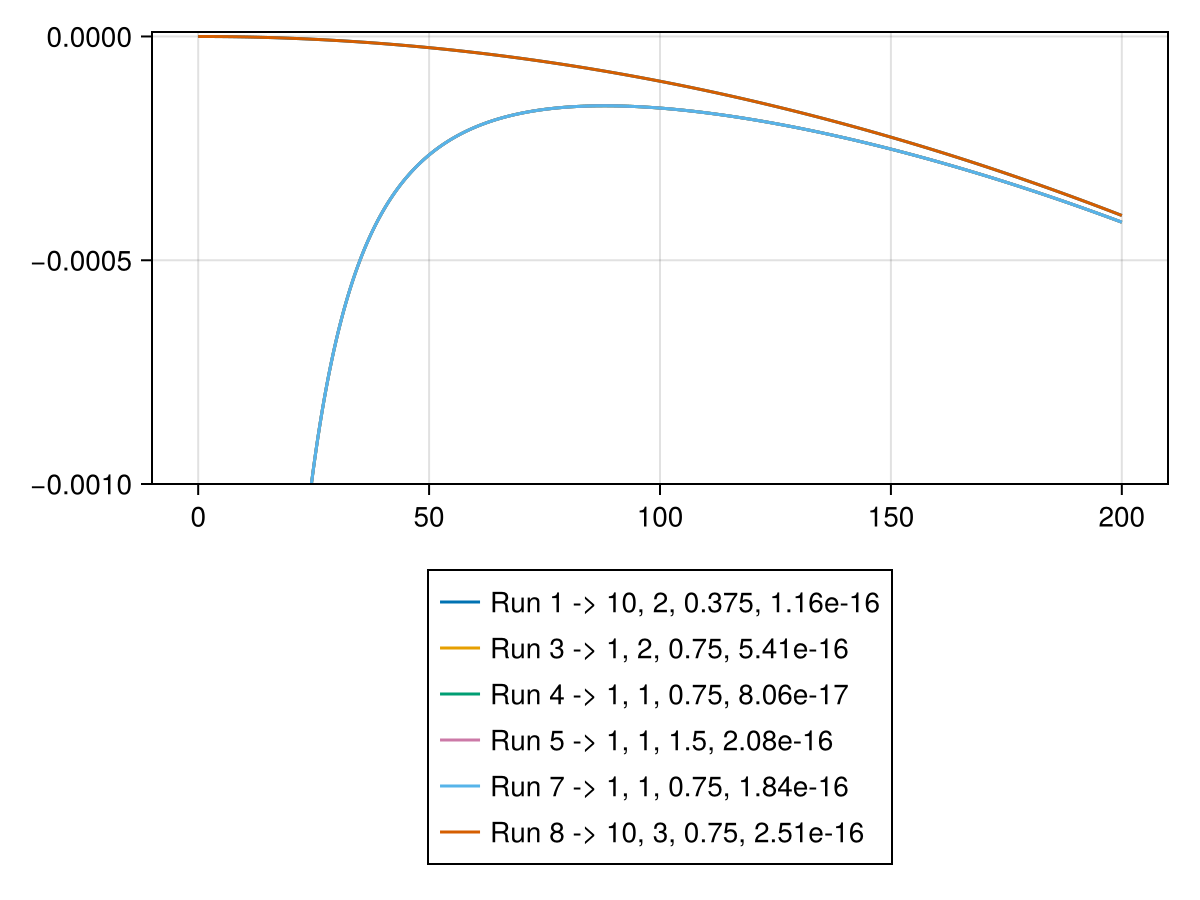

In [5]:
rsg = RSGJans1(10, 10;
    m=(0.4, 0.0000),
    r=1.,
    Kp=0.1, K=1.0,
    
    c=(2., 0.),
    l=0.5,
    sparsity_resources=0.1,
    sparsity_byproducts=0.1,
    
    DS=1e-8, DR=1.,
)
@time f, xx, ints = rg_run_plot_dispersions(rsg, 10, 200., 1000;
    reltol=eps(),
    abstol=eps(),
    maxresidthr=10*eps(),
    lszerothr=1e-12,
    int_codes=[10, 11, 12]
)
display(freqtable(xx))
ylims!(f.current_axis[], (-0.001, 0.00001))
# xlims!(f.current_axis[], (-1, 1) .* 10)
# display(GLMakie.Screen(), f)
f

In [456]:
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

# Running a single system

In [457]:
ps = rsg();

In [60]:
ps = ints[2];

## No space solver

In [78]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps()
);
maximum(abs, sss.resid)

  0.019312 seconds (13.48 k allocations: 2.528 MiB)


1.4293987275738484e-16

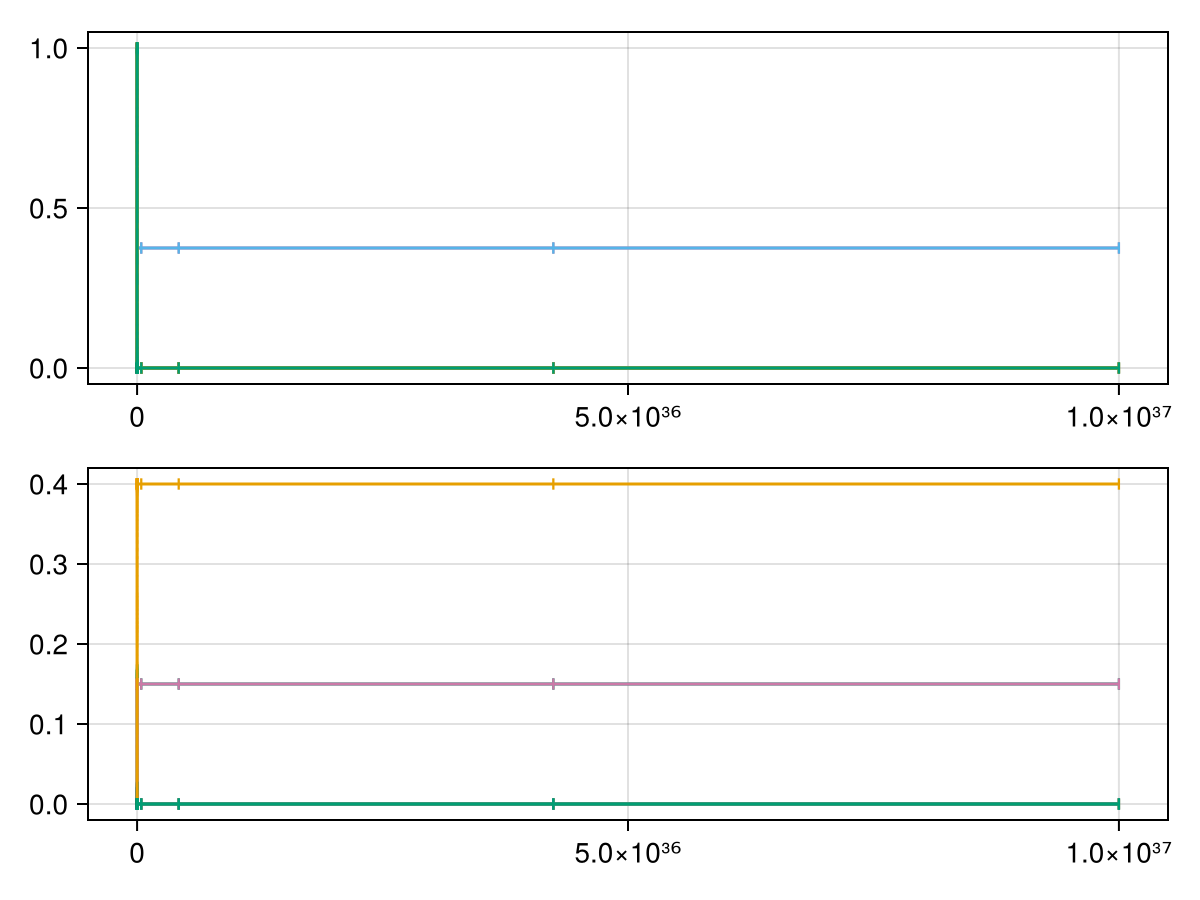

In [109]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 10000000000000000000000000000000000000);

s = solve(p, QNDF())

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

## Spatial stuff

In [43]:
# nssol = s.u[end];
nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 1.4571677198205897e-16


### Linear stability

In [44]:
ks = LinRange(0., 10000., 10000)

lamfunc = linstab_make_k_func(ps, nssol)
lambdas = lamfunc.(ks);

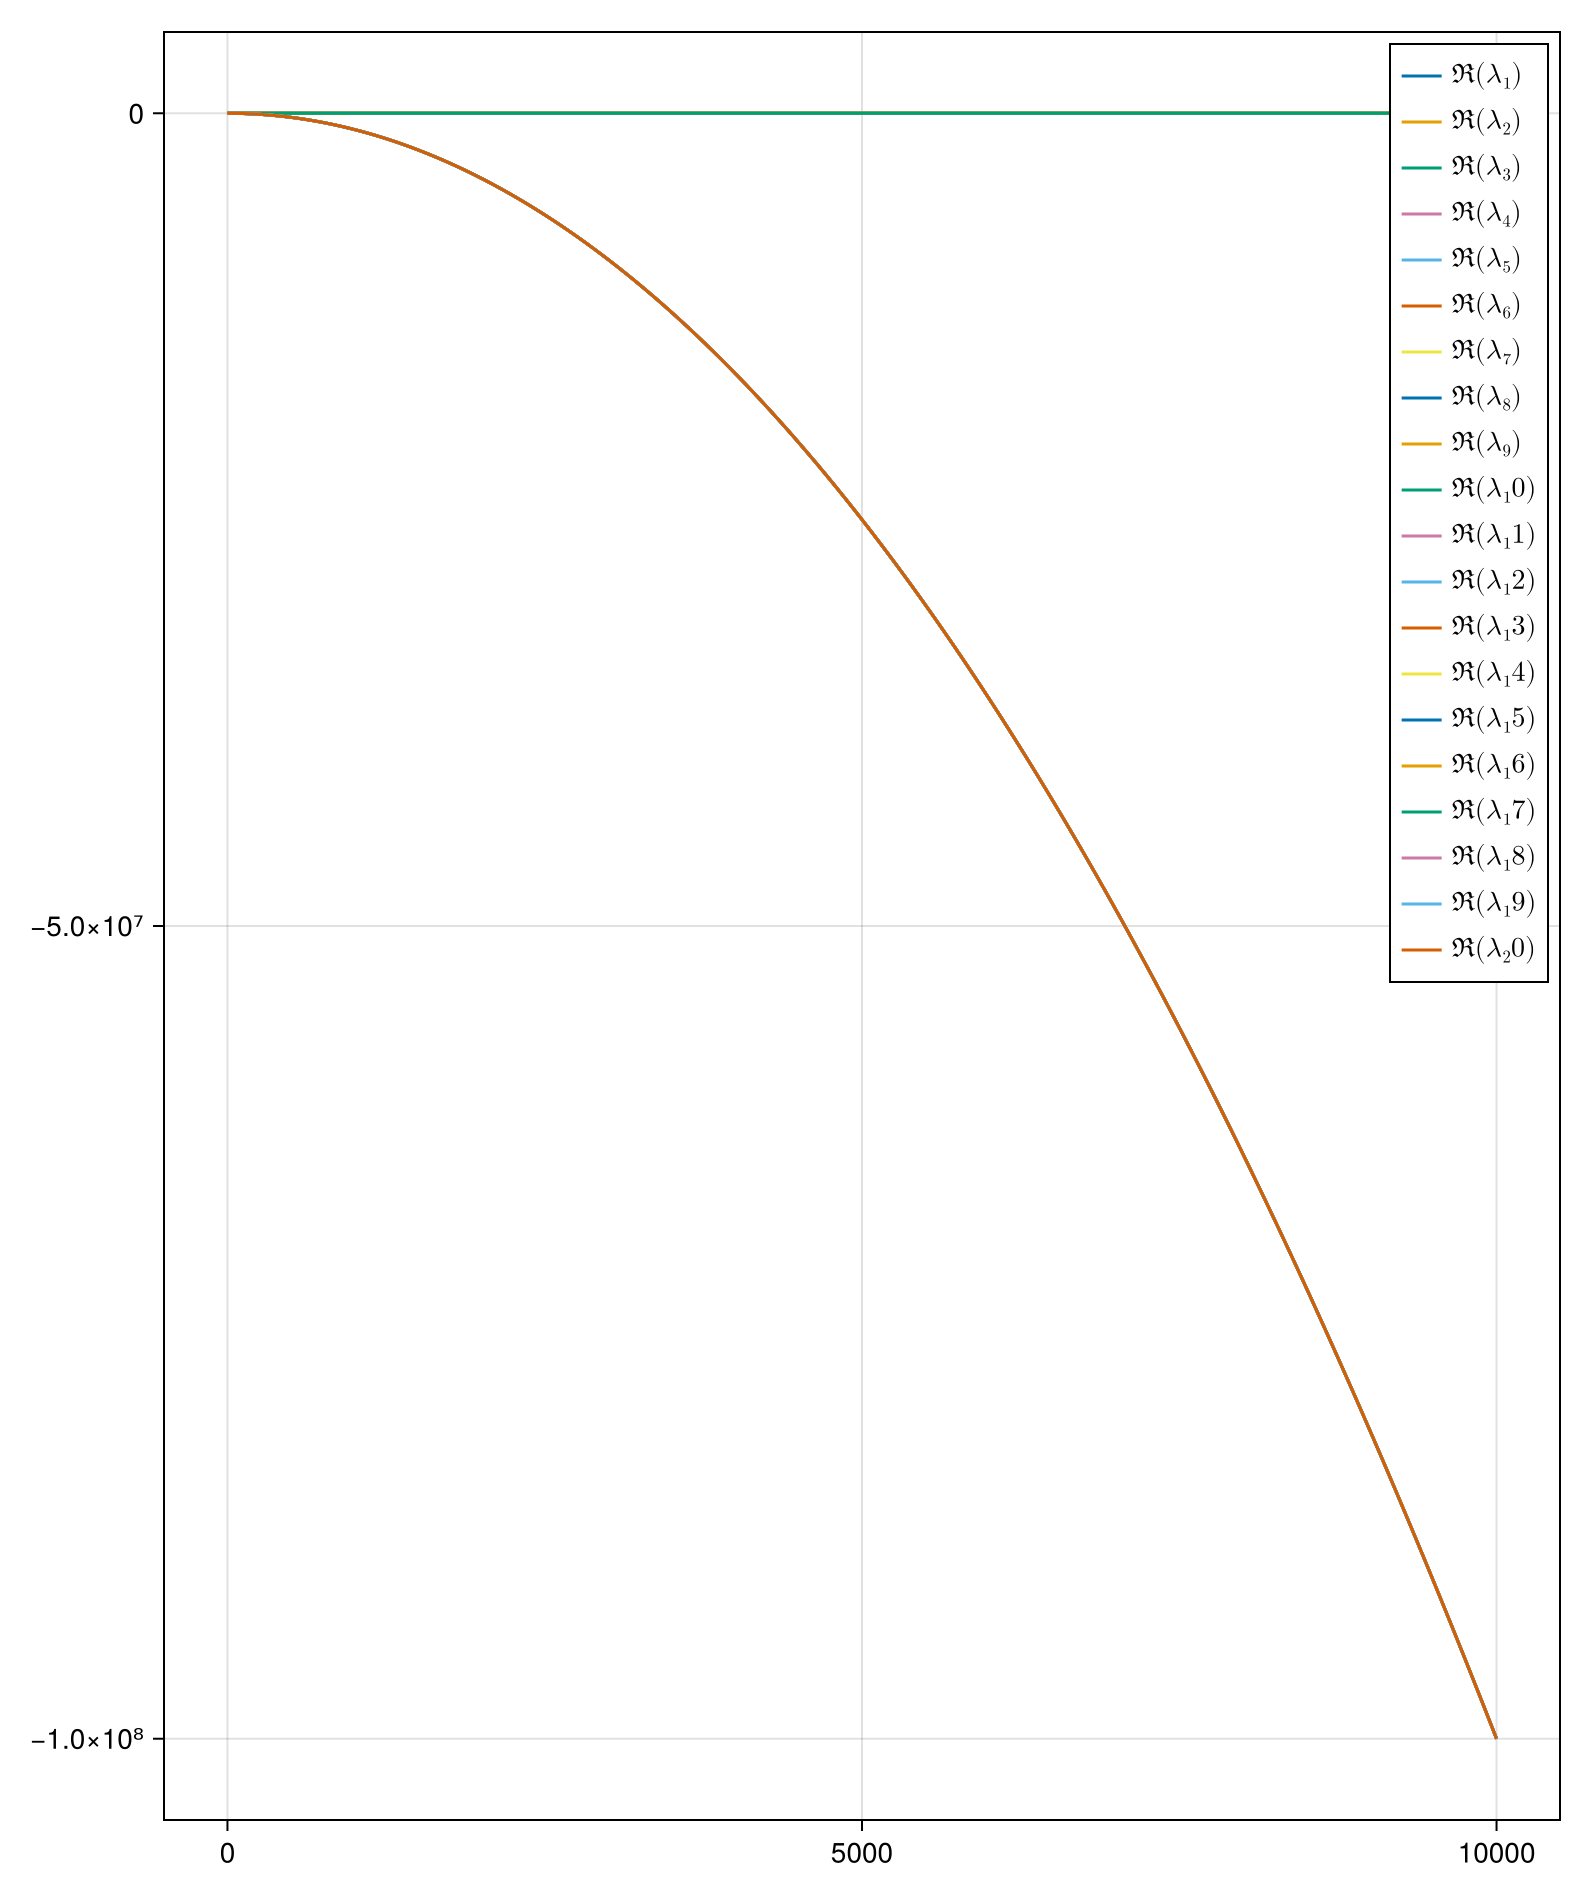

In [45]:
faa = plot_linstab_lambdas(ks, lambdas)
display(GLMakie.Screen(), faa.figure)
faa

### 1D spatial

In [89]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [90]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

 20.937264 seconds (128.32 k allocations: 5.782 GiB, 2.01% gc time)
Success
nf is 880
solution has 150 saved states
max resid is 2.00273e-11


┌ Warning: reaching negative values, minimum is -3.32617e-06
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


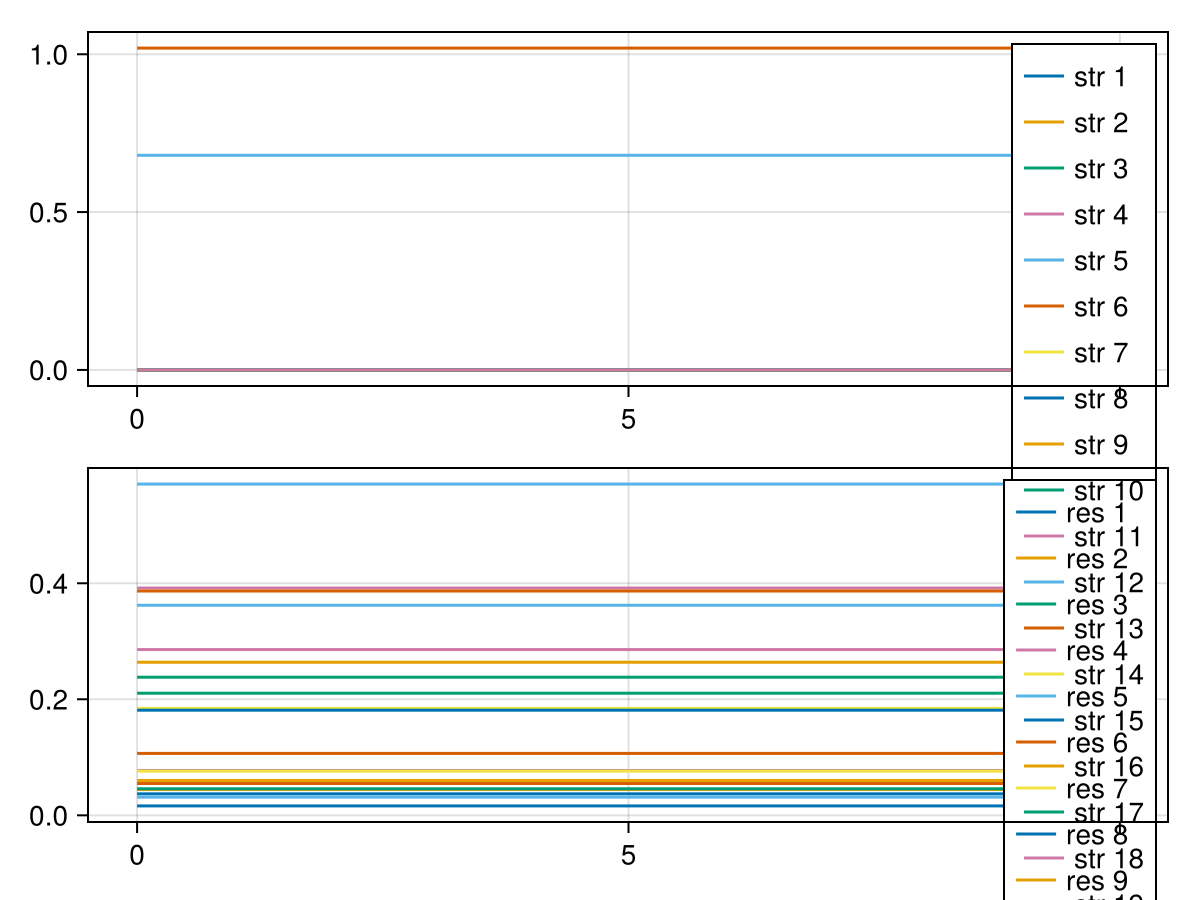

In [105]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[150])

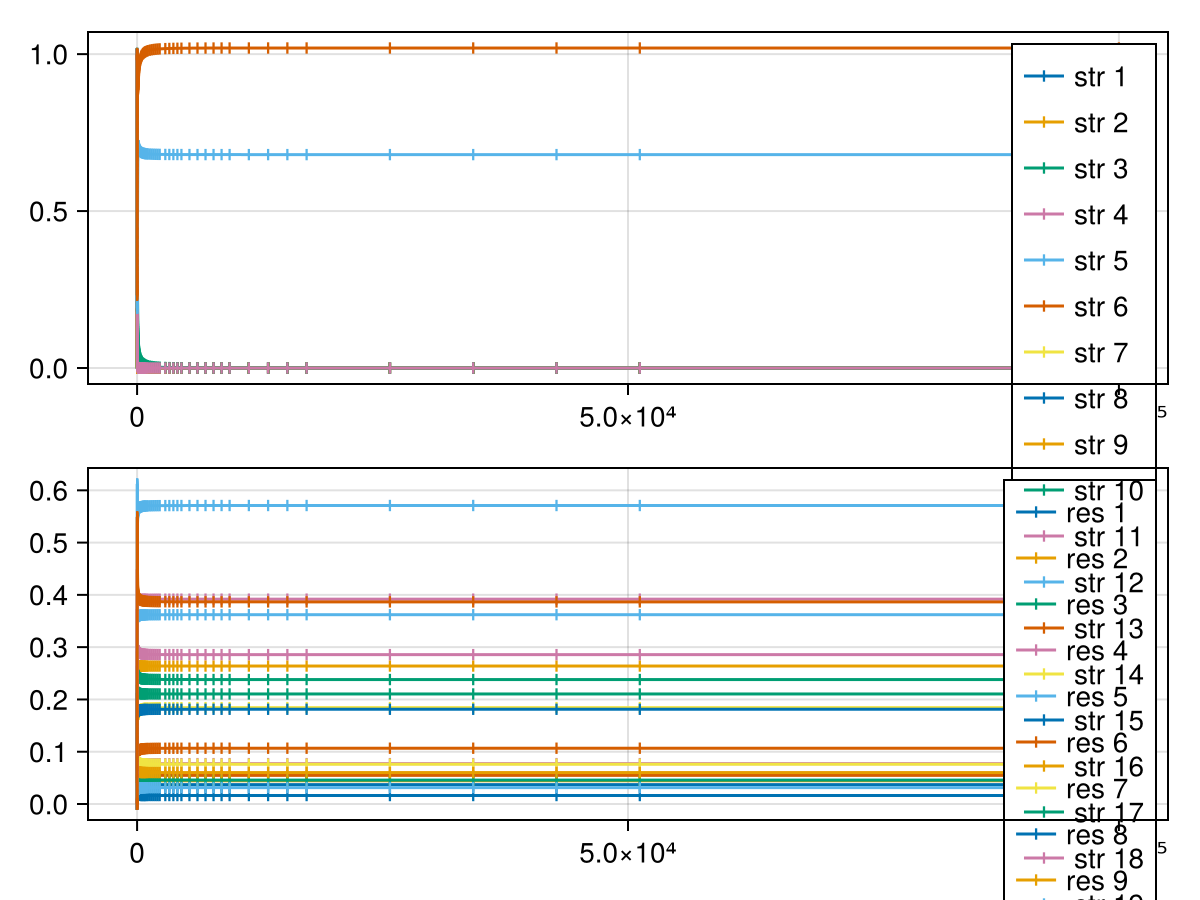

In [92]:
plot_smmicrm_sol_avgs(sps)

# Things I want to save for reference!

## What I thought gave many instabilities but wat just k=0 ~ 1e-10

In [213]:
rsg = RSGJans1(20, 20;
    m=0.9, # increasing m we quickly lose them!
    r=0.2,
    Kp=0.2, K=0.5,
    
    c=4.,
    l=0.5,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)
@time xx = example_do_rg_run(rsg, 100, LinRange(0., 100., 1000);
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6
)
freqtable(xx)

Generating one params: 0.000020 seconds (153 allocations: 92.625 KiB)
  2.313998 seconds (26.95 M allocations: 4.488 GiB)


1-element Named Vector{Int64}
Dim1  │ 
──────┼────
1     │ 100

In [106]:
@time yy = example_do_rg_run(rsg, 1, LinRange(0., 100., 1000),
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6,
    return_interesting=true
)
@show length(yy[2])
freqtable(yy[1])

Generating one params: 0.000012 seconds (42 allocations: 12.844 KiB)
  0.012593 seconds (48.18 k allocations: 35.942 MiB)
length(yy[2]) = 0


1-element Named Vector{Int64}
Dim1  │ 
──────┼──
1     │ 1

In [88]:
ps = yy[2][1];

# Bigger runs

In [114]:
bigrsg = RSGJans1(50, 50;
    m=1.,
    r=1.,
    Kp=0.1, K=10.0,
    
    c=(2., 1.),
    l=0.2,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)

@time xx = do_rg_run(rsgj, 1000, LinRange(0., 1000., 1000);
    extinctthreshold=1e-5
)

jldsave(datadir("randomsystems/prelim", randname()*".jld2");
    rsg=bigrsg,
    output=xx
)

freqtable(xx)

Generating one params: 0.000501 seconds (865 allocations: 1.265 MiB)
451.332197 seconds (3.80 G allocations: 174.887 GiB, 4.30% gc time, 0.00% compilation time)


3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │  14
1     │ 985
2     │   1

## Looking/comparing saved data

In [128]:
f = jldopen("../data/randomsystems/prelim/Proactive-Fuchsia-Mongoose.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   9
1     │ 987
2     │   4

In [134]:
f = jldopen("../data/randomsystems/prelim/Likable-Periwinkle-Viper.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   2
1     │ 994
2     │   4

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()